In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from langdetect import detect_langs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from nltk import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
df = pd.read_csv('ratebeer.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,name,id,brewerID,abv,style,appearance,aroma,palate,taste,overall,time,profileName,reviewtext
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,5-Apr,10-Jun,5-Mar,10-Jun,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale &#40;IPA&#41;,5-Apr,10-Jun,5-Apr,10-Jul,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,5-Apr,10-May,5-Mar,10-Jun,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne..."
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,5-Feb,10-Apr,5-Feb,10-Apr,20-Aug,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Kölsch,5-Feb,10-Apr,5-Feb,10-Apr,20-Aug,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."


In [4]:
df_1 = df.sample(frac=0.25)

In [5]:
df_1.shape

(262144, 13)

In [6]:
df_2 = df.sample(frac=0.05)
df_2.shape

(52429, 13)

In [7]:
df_3 = df_2[['name', 'reviewtext']]

In [8]:
df_3.head()

,name,reviewtext
577169,Baeren Fest Bier,"UPDATED: SEP 21, 2009 2009 version, draught at..."
998745,Ecaussinnes Penneffoise,"Thick, cloudy brown pour with lots of floaties..."
154467,New Holland Night Tripper,Bottle shared at a Portland BA/RB tasting held...
686323,Lion Brewery India Pale Ale,"Very pale yellow, translucent. Visually, very ..."
203153,Oggis Sunset Amber Ale,"Draft. Auburn amber, small white head. Grass..."


In [9]:
df_3 = df_3.rename(columns={'reviewtext': 'review'})

In [10]:
# length of the reviews
length_reviews = df_3.review.str.len()

In [11]:
df_3['length'] = length_reviews

In [12]:
df_3.head()

,name,review,length
577169,Baeren Fest Bier,"UPDATED: SEP 21, 2009 2009 version, draught at...",544.0
998745,Ecaussinnes Penneffoise,"Thick, cloudy brown pour with lots of floaties...",572.0
154467,New Holland Night Tripper,Bottle shared at a Portland BA/RB tasting held...,287.0
686323,Lion Brewery India Pale Ale,"Very pale yellow, translucent. Visually, very ...",193.0
203153,Oggis Sunset Amber Ale,"Draft. Auburn amber, small white head. Grass...",205.0


In [13]:
avg_length = df_3.length.mean()
print('Average Length: {}'.format(avg_length))

Average Length: 310.4010618590172


In [14]:
longest_review = df_3['length'].max()
shortest_review = df_3['length'].min()
print('Longest Review: {}'.format(longest_review))
print('Shortest Review: {}'.format(shortest_review))

Longest Review: 4343.0
Shortest Review: 4.0


In [15]:
df_4 = df_3.sort_values(by=['length'], ascending=False)
df_4.head()

,name,review,length
657697,Cigar City Warmer Winter Winter Warmer,A steady pour seems to be doing pretty well so...,4343.0
607898,Full Sail Old Boardhead Barleywine,"UPDATED: FEB 25, 2010 Full Sail Brewing Compan...",3944.0
240479,Stone Old Guardian &#40;Vintages through 2003&...,"UPDATED: OCT 12, 2008 Name: Old Guardian\tDate...",3854.0
323862,Snoqualmie Falls Summer Beer,"UPDATED: MAY 15, 2010 Snoqualmie Falls Brewing...",3688.0
806560,Keystone Light,We all know theres an unwritten rule among bee...,3515.0


In [16]:
# Detect the language of the review

In [17]:
reviews = df_4.sample(frac=0.50)
reviews.head()

,name,review,length
39761,Anderson Valley Barney Flats Oatmeal Stout,Blind tasting. Black w/ decent head. A little ...,127.0
120765,Nectar Ales Nectar IPA,Pours clear and copper with one finger ivory h...,187.0
285455,Alpine Beer Company Ichabod Ale,"Bottle, courtesy of Tom Nickel (owner of Orien...",522.0
629419,Ayinger Altbairisch Dunkel,Brownish pour with a foamy white head. Some l...,406.0
796444,Town Hall Banana Bread Beer,"Intriguing idea. Execution, not so much. Clo...",239.0


In [18]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26214 entries, 39761 to 952872
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    26214 non-null  object 
 1   review  26175 non-null  object 
 2   length  26175 non-null  float64
dtypes: float64(1), object(2)
memory usage: 819.2+ KB


In [19]:
review = str(reviews.review)

In [20]:
languages = []

for r in range(len(reviews)):
    languages.append(detect_langs(reviews.iloc[r, 0]))

In [22]:
languages = [str(lang).split(':')[0][1] for lang in languages]

In [23]:
reviews['lang'] = languages

In [24]:
reviews.head()

,name,review,length,lang
39761,Anderson Valley Barney Flats Oatmeal Stout,Blind tasting. Black w/ decent head. A little ...,127.0,e
120765,Nectar Ales Nectar IPA,Pours clear and copper with one finger ivory h...,187.0,c
285455,Alpine Beer Company Ichabod Ale,"Bottle, courtesy of Tom Nickel (owner of Orien...",522.0,e
629419,Ayinger Altbairisch Dunkel,Brownish pour with a foamy white head. Some l...,406.0,d
796444,Town Hall Banana Bread Beer,"Intriguing idea. Execution, not so much. Clo...",239.0,e


In [25]:
# Removing non english reviews and Keeping only reviews in english

reviews_e = reviews.loc[lambda reviews: reviews['lang'] == 'e']
reviews_e

,name,review,length,lang
39761,Anderson Valley Barney Flats Oatmeal Stout,Blind tasting. Black w/ decent head. A little ...,127.0,e
285455,Alpine Beer Company Ichabod Ale,"Bottle, courtesy of Tom Nickel (owner of Orien...",522.0,e
796444,Town Hall Banana Bread Beer,"Intriguing idea. Execution, not so much. Clo...",239.0,e
540024,Boddingtons Pub Ale &#40;Can&#41;,I was really disappointed with this beer. Pou...,178.0,e
569532,Fat Heads Spring Fest,On tap at Fat Heads on 3/27/10. Clear gold pou...,249.0,e
...,...,...,...,...
231965,Stone Imperial Russian Stout,Bottled Summer 2005\t\tJesus. They really didn...,1432.0,e
579073,Melbourn Brothers Cherry,"(Bottle 35,5 cl) Slightly hazy dark red with a...",204.0,e
393825,Shipyard Pumpkinhead Ale,From bottle : Pours a very light gold with sma...,324.0,e
127289,Iron Hill Russian Imperial Stout,Courtesy of Secret Santa July 07\tBottle: The...,492.0,e


In [26]:
avg_length_e = reviews_e.length.mean()
longest_review_e = reviews_e['length'].max()
shortest_review_e = reviews_e['length'].min()
print('Average Length: {}'.format(avg_length_e))
print('Longest Review: {}'.format(longest_review_e))
print('Shortest Review: {}'.format(shortest_review_e))

Average Length: 322.7213258377747
Longest Review: 4343.0
Shortest Review: 5.0


In [27]:
reviews_e['review'] = reviews_e['review'].astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
reviews_e['sentiment'] = round(reviews_e['review'].apply(lambda x: TextBlob(x).sentiment[0]),2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
reviews_e

,name,review,length,lang,sentiment
39761,Anderson Valley Barney Flats Oatmeal Stout,Blind tasting. Black w/ decent head. A little ...,127.0,e,-0.06
285455,Alpine Beer Company Ichabod Ale,"Bottle, courtesy of Tom Nickel (owner of Orien...",522.0,e,0.22
796444,Town Hall Banana Bread Beer,"Intriguing idea. Execution, not so much. Clo...",239.0,e,-0.01
540024,Boddingtons Pub Ale &#40;Can&#41;,I was really disappointed with this beer. Pou...,178.0,e,-0.01
569532,Fat Heads Spring Fest,On tap at Fat Heads on 3/27/10. Clear gold pou...,249.0,e,0.05
...,...,...,...,...,...
231965,Stone Imperial Russian Stout,Bottled Summer 2005\t\tJesus. They really didn...,1432.0,e,0.04
579073,Melbourn Brothers Cherry,"(Bottle 35,5 cl) Slightly hazy dark red with a...",204.0,e,-0.02
393825,Shipyard Pumpkinhead Ale,From bottle : Pours a very light gold with sma...,324.0,e,0.05
127289,Iron Hill Russian Imperial Stout,Courtesy of Secret Santa July 07\tBottle: The...,492.0,e,0.05


In [30]:
reviews_e.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13712 entries, 39761 to 179142
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       13712 non-null  object 
 1   review     13712 non-null  object 
 2   length     13697 non-null  float64
 3   lang       13712 non-null  object 
 4   sentiment  13712 non-null  float64
dtypes: float64(2), object(3)
memory usage: 642.8+ KB


In [31]:
reviews_1 = reviews_e

In [32]:
reviews_1.reset_index(drop=True, inplace=True)

In [33]:
reviews_1.head()

,name,review,length,lang,sentiment
0,Anderson Valley Barney Flats Oatmeal Stout,Blind tasting. Black w/ decent head. A little ...,127.0,e,-0.06
1,Alpine Beer Company Ichabod Ale,"Bottle, courtesy of Tom Nickel (owner of Orien...",522.0,e,0.22
2,Town Hall Banana Bread Beer,"Intriguing idea. Execution, not so much. Clo...",239.0,e,-0.01
3,Boddingtons Pub Ale &#40;Can&#41;,I was really disappointed with this beer. Pou...,178.0,e,-0.01
4,Fat Heads Spring Fest,On tap at Fat Heads on 3/27/10. Clear gold pou...,249.0,e,0.05


In [34]:
reviews_1.iloc[0]

name                Anderson Valley Barney Flats Oatmeal Stout
review       Blind tasting. Black w/ decent head. A little ...
length                                                     127
lang                                                         e
sentiment                                                -0.06
Name: 0, dtype: object

In [35]:
sentiment_1 = []

for i in range(len(reviews_1)):
    if reviews_1.sentiment[i] >= 0.10:
        sentiment_1.append(2)
    elif reviews_1.sentiment[i] >= -0.10:
        sentiment_1.append(0)
    else:
        sentiment_1.append(1)

In [36]:
reviews_1['sentiment_1'] = sentiment_1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
reviews_1

,name,review,length,lang,sentiment,sentiment_1
0,Anderson Valley Barney Flats Oatmeal Stout,Blind tasting. Black w/ decent head. A little ...,127.0,e,-0.06,0
1,Alpine Beer Company Ichabod Ale,"Bottle, courtesy of Tom Nickel (owner of Orien...",522.0,e,0.22,2
2,Town Hall Banana Bread Beer,"Intriguing idea. Execution, not so much. Clo...",239.0,e,-0.01,0
3,Boddingtons Pub Ale &#40;Can&#41;,I was really disappointed with this beer. Pou...,178.0,e,-0.01,0
4,Fat Heads Spring Fest,On tap at Fat Heads on 3/27/10. Clear gold pou...,249.0,e,0.05,0
...,...,...,...,...,...,...
13707,Stone Imperial Russian Stout,Bottled Summer 2005\t\tJesus. They really didn...,1432.0,e,0.04,0
13708,Melbourn Brothers Cherry,"(Bottle 35,5 cl) Slightly hazy dark red with a...",204.0,e,-0.02,0
13709,Shipyard Pumpkinhead Ale,From bottle : Pours a very light gold with sma...,324.0,e,0.05,0
13710,Iron Hill Russian Imperial Stout,Courtesy of Secret Santa July 07\tBottle: The...,492.0,e,0.05,0


In [38]:
reviews_1['sentiment_1'].value_counts()

2    8931
0    4033
1     748
Name: sentiment_1, dtype: int64

In [39]:
reviews_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13712 entries, 0 to 13711
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         13712 non-null  object 
 1   review       13712 non-null  object 
 2   length       13697 non-null  float64
 3   lang         13712 non-null  object 
 4   sentiment    13712 non-null  float64
 5   sentiment_1  13712 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 642.9+ KB


In [40]:
reviews_1.sentiment_1[0]

0

In [41]:
range(len(reviews_1.sentiment_1))

range(0, 13712)

In [42]:
positive = []
negative = []
neutral = []

for i in range(len(reviews_1.sentiment_1)-1):
    if reviews_1.sentiment_1[i] == 2:
        positive.append(reviews_1.review[i])
    elif reviews_1.sentiment_1[i] == 1:
        negative.append(reviews_1.review[i])
    else:
        neutral.append(reviews_1.review[i])
   

In [43]:
len(review)

702

In [44]:
len(reviews_1.sentiment_1)-1

13711

In [45]:
print(len(positive))
print(len(negative))
print(len(neutral))

8930
748
4033


In [46]:
positive_string = str(positive)
negative_string = str(negative)
neutral_string = str(neutral)

In [47]:
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

In [47]:
my_stop_words = ENGLISH_STOP_WORDS.union(['Aroma', 'head', 'is'])

In [48]:
positive_cloud = WordCloud(stopwords = my_stop_words).generate(positive_string)

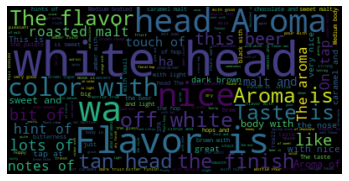

In [49]:
plt.imshow(positive_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

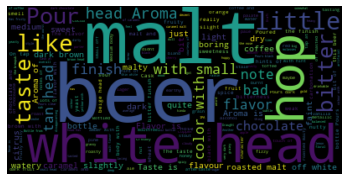

In [50]:
negative_cloud = WordCloud(stopwords=my_stop_words).generate(negative_string)
plt.imshow(negative_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

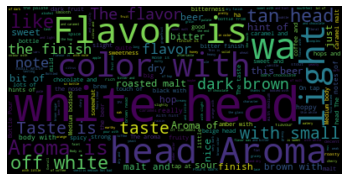

In [149]:
neutral_cloud = WordCloud(stopwords=my_stop_words).generate(neutral_string)
plt.imshow(neutral_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [140]:
# Tokenizing words

In [52]:
word_tokens = [word_tokenize(review) for review in reviews_1.review]

In [53]:
cleaned_tokens = [[word for word in items if word.isalpha()]for items in word_tokens]

In [54]:
print(len(word_tokens))
print(len(cleaned_tokens))

13712
13712


In [56]:
print(word_tokens[0])

['growler', 'from', 'superdave', '2/13/11', '.', 'dark', '.', 'black', 'coffee', 'color', 'with', 'a', 'tan', 'head', '.', 'spots', 'of', 'foam', 'get', 'left', 'behind', 'as', 'the', 'head', 'retreats', '.', 'aromas', 'of', 'coffee', ',', 'cream/lactose', ',', 'mild', 'ash', ',', 'chocolate', ',', 'dark', 'raisins', 'and', 'loads', 'of', 'cotton', 'candy', '.', 'the', 'palate', 'is', 'only', 'mildly', 'sweet', '...', 'big', 'doses', 'of', 'drying', 'hops', 'keep', 'it', 'in', 'check', 'enough', 'to', 'become', 'enjoyable', '.', 'add', 'in', 'a', 'rather', 'thinnish', 'body', '(', 'for', 'the', 'style', ',', 'traditionally', ')', 'and', 'i', 'could', 'get', 'into', 'this', '.', 'the', 'flavor', 'shares', 'most', 'of', 'the', 'notes', 'from', 'the', 'aroma', '...', 'but', 'there', 'is', 'a', 'coconut-brown', 'sugar-chocolate', 'chip-', 'cookie', 'thing', 'going', 'on', 'without', 'the', 'sugar', '.', 'i', 'like', 'its', 'unbarleywine', '...', '7/4/7/4/14']


In [57]:
print(cleaned_tokens[0])

['growler', 'from', 'superdave', 'dark', 'black', 'coffee', 'color', 'with', 'a', 'tan', 'head', 'spots', 'of', 'foam', 'get', 'left', 'behind', 'as', 'the', 'head', 'retreats', 'aromas', 'of', 'coffee', 'mild', 'ash', 'chocolate', 'dark', 'raisins', 'and', 'loads', 'of', 'cotton', 'candy', 'the', 'palate', 'is', 'only', 'mildly', 'sweet', 'big', 'doses', 'of', 'drying', 'hops', 'keep', 'it', 'in', 'check', 'enough', 'to', 'become', 'enjoyable', 'add', 'in', 'a', 'rather', 'thinnish', 'body', 'for', 'the', 'style', 'traditionally', 'and', 'i', 'could', 'get', 'into', 'this', 'the', 'flavor', 'shares', 'most', 'of', 'the', 'notes', 'from', 'the', 'aroma', 'but', 'there', 'is', 'a', 'cookie', 'thing', 'going', 'on', 'without', 'the', 'sugar', 'i', 'like', 'its', 'unbarleywine']


In [55]:
print(len(word_tokens[0]))
print(len(cleaned_tokens[0]))

24
19


In [59]:
# Stemming & Lemmatizing

In [60]:
lemmatizer = WordNetLemmatizer()

In [61]:
lem_tokens = [[lemmatizer.lemmatize(word) for word in token]for token in cleaned_tokens]

In [62]:
print(len(lem_tokens[0]))

94


In [63]:
porter = PorterStemmer()

In [64]:
stemmed_tokens = [[porter.stem(word) for word in token]for token in cleaned_tokens]

In [65]:
print(len(stemmed_tokens[0]))

94


In [187]:
# nlp = spacy.load('en_core_web_sm')

In [196]:
# review_string = str(reviews_1.review)
# print(review_string)

In [189]:
# doc = nlp(review_string)
# len(doc)

In [190]:
# lemmas = [token.lemma_ for token in doc]

In [191]:
# len(lemmas[0])

In [192]:
# a_lemmas = [lemma for lemma in lemmas if lemma.isalpha()]

In [193]:
# print(' '.join(a_lemmas))

In [194]:
# len(a_lemmas[0])

In [56]:
reviews_1.review

0        Blind tasting. Black w/ decent head. A little ...
1        Bottle, courtesy of Tom Nickel (owner of Orien...
2        Intriguing idea.  Execution, not so much.  Clo...
3        I was really disappointed with this beer.  Pou...
4        On tap at Fat Heads on 3/27/10. Clear gold pou...
                               ...                        
13707    Bottled Summer 2005\t\tJesus. They really didn...
13708    (Bottle 35,5 cl) Slightly hazy dark red with a...
13709    From bottle : Pours a very light gold with sma...
13710    Courtesy of Secret Santa July 07\tBottle:  The...
13711    12oz bottle from MotorToddHead.  Thanks Todd! ...
Name: review, Length: 13712, dtype: object

In [57]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000, stop_words='english')

In [58]:
vectorizer.fit(reviews_1.review)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=10000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [59]:
review_text = vectorizer.transform(reviews_1.review)

In [60]:
review_df = pd.DataFrame(review_text.toarray(), columns=vectorizer.get_feature_names())

In [61]:
review_df

,00,01,01 10,02,03,04,05,06,07,07 bottle,...,yuck,yulesmith,yum,yummy,zero,zero head,zest,zest light,zesty,zing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122816,0.177992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
review_df['sentiment'] = reviews_1['sentiment_1']

In [63]:
review_df['name'] = reviews_1['name']

In [64]:
review_df.head()

,00,01,01 10,02,03,04,05,06,07,07 bottle,...,yum,yummy,zero,zero head,zest,zest light,zesty,zing,sentiment,name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Anderson Valley Barney Flats Oatmeal Stout
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Alpine Beer Company Ichabod Ale
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Town Hall Banana Bread Beer
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Boddingtons Pub Ale &#40;Can&#41;
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Fat Heads Spring Fest


In [65]:
y = review_df['sentiment']

In [66]:
X = review_df.drop('sentiment', axis=1)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
lr = LogisticRegression()

In [69]:
lr.fit(X_train.drop('name', axis=1), y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
y_pred = lr.predict(X_test.drop('name', axis=1))

In [71]:
print("Accuracy_score: \n {}".format(accuracy_score(y_test, y_pred)))

Accuracy_score: 
 0.7838133430550492


In [72]:
print("Confusion Matrix: \n {}".format(confusion_matrix(y_test, y_pred)))

Confusion Matrix: 
 [[ 458    2  347]
 [ 117    9   24]
 [ 103    0 1683]]


In [73]:
proba = lr.predict_proba(X_test.drop('name', axis=1))

In [74]:
proba

array([[2.84578145e-01, 7.60059101e-02, 6.39415945e-01],
       [4.97268774e-01, 4.55908974e-02, 4.57140329e-01],
       [3.37107638e-01, 5.10623711e-02, 6.11829991e-01],
       ...,
       [2.41573377e-01, 4.98330081e-02, 7.08593615e-01],
       [1.03012274e-03, 8.70267980e-05, 9.98882850e-01],
       [5.06396619e-01, 5.01649909e-02, 4.43438391e-01]])

In [75]:
y_pred

array([2, 0, 2, ..., 2, 2, 0])

In [76]:
X_test.head()

,00,01,01 10,02,03,04,05,06,07,07 bottle,...,yulesmith,yum,yummy,zero,zero head,zest,zest light,zesty,zing,name
10135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Goose Island Bourbon Sherry Beer
7964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sly Fox Phoenix Pale Ale
5300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brewers Art Resurrection
10556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Spanish Peaks Summer White
7477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Full Sail Sanctuary Belgian Style Dubbel


In [77]:
X_test.reset_index(drop=True, inplace=True)

In [78]:
X_test

,00,01,01 10,02,03,04,05,06,07,07 bottle,...,yulesmith,yum,yummy,zero,zero head,zest,zest light,zesty,zing,name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Goose Island Bourbon Sherry Beer
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sly Fox Phoenix Pale Ale
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Brewers Art Resurrection
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Spanish Peaks Summer White
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Full Sail Sanctuary Belgian Style Dubbel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Thornbridge Lord Marples
2739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Catamount Porter
2740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Donnington SBA
2741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Samuel Smiths Nut Brown Ale


In [79]:
pred_df = pd.DataFrame(X_test['name'], y_pred)
pred_df

,name
2,Brewers Art Resurrection
0,Goose Island Bourbon Sherry Beer
2,Brewers Art Resurrection
0,Goose Island Bourbon Sherry Beer
2,Brewers Art Resurrection
...,...
2,Brewers Art Resurrection
2,Brewers Art Resurrection
2,Brewers Art Resurrection
2,Brewers Art Resurrection


In [80]:
pred_df.to_csv('prediction.csv')

In [166]:
#  Increase the features to 50000

In [91]:
vectorizer_1 = TfidfVectorizer(ngram_range=(1,2), max_features=50000, stop_words='english')
vectorizer_1.fit(reviews_1.review)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=50000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [92]:
review_text_1 = vectorizer_1.transform(reviews_1.review)
review_df_1 = pd.DataFrame(review_text_1.toarray(), columns=vectorizer_1.get_feature_names())

In [93]:
review_df_1.head()

,00,00 abv,00 taco,000,01,01 08,01 11,01 2006,01 2008,01 2009,...,zing flavor,zing slakes,zingy,zingy citrus,zip,zippy,zombie,zoo,zum,zum ende
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
review_df_1['sentiment'] = reviews_1['sentiment_1']
review_df_1['name'] = reviews_1['name']
review_df_1.head()

,00,00 abv,00 taco,000,01,01 08,01 11,01 2006,01 2008,01 2009,...,zingy,zingy citrus,zip,zippy,zombie,zoo,zum,zum ende,sentiment,name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,SanTan Sex Panther
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Lagunitas Wilco Tango Foxtrot &#40;WTF&#41; Ale
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Lagunitas Kill Ugly Radio
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Library Rabbit Bay Brown Ale
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Town Hall Number 9


In [98]:
y_1 = review_df_1['sentiment']
X_1 = review_df_1.drop('sentiment', axis=1)

In [99]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42, stratify=y_1)
lr_1 = LogisticRegression()
lr_1.fit(X_train_1.drop('name', axis=1), y_train_1)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [101]:
y_predict = lr_1.predict(X_test_1.drop('name', axis=1))

In [102]:
print("Accuracy_score: \n {}".format(accuracy_score(y_test_1, y_predict)))

Accuracy_score: 
 0.7780195865070729


In [167]:
# Random forest with 10000 features


In [103]:
rf = RandomForestClassifier()
rf.fit(X_train.drop('name', axis=1), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [104]:
pred_y = rf.predict(X_test.drop('name', axis=1))
print("Accuracy_score: \n {}".format(accuracy_score(y_test, pred_y)))

Accuracy_score: 
 0.7170837867247007


In [81]:
test = pd.read_csv('reviews.csv')
test

,review
0,Fruity aroma on the nose which made me think i...
1,I don't typically like stouts but decided to t...
2,Pils are my favorite beer so I'm sorry to say ...
3,Pours very dark brown with a small short-lasti...
4,Peach juice colour. Bubbly head. Aroma is rasp...
5,Hazy golden colour. Aroma is grassy with some ...
6,"Very clear, pale amber nearing lemon. Only sma..."
7,The beer is a hazy copper-red color with a med...
8,I'm not much of a stout guy buy enjoyed the 20...
9,Interesting pour to this as it had a blueberry...


In [85]:
test_vect = vectorizer.transform(test.review)

In [88]:
test_df = pd.DataFrame(test_vect.toarray(), columns = vectorizer.get_feature_names())

In [89]:
test_df.shape

(21, 927)

In [93]:
test_df.head()

,2019,2020,2020 version,86,86 case,abv,abv liquid,accented,accented vague,accents,...,wood sparks,worth,worth 86,yellow,yellow pour,yellow small,yields,yields chunky,zest,zest herbs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
predict_test = lr.predict(test_df)

ValueError: X has 927 features per sample; expecting 10000

In [82]:
pl = Pipeline([
    ('vect', vectorizer),
    ('clf', lr)
])

In [109]:
count_vect = CountVectorizer(ngram_range=(1,2), max_features=10000, stop_words='english')
count_vect.fit(reviews_1.review)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [147]:
review_text_count = count_vect.transform(reviews_1.review)

print(type(review_text_count))
print(pd.DataFrame(review_text_count.toarray()).shape)
print(review_text_count.toarray())
##print(count_vect.get_feature_names())
##print(reviews_1.review)

<class 'scipy.sparse.csr.csr_matrix'>
(13712, 10000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [123]:
tfidf_trans = TfidfTransformer().fit(review_text_count)

In [148]:
training_tfidf = tfidf_trans.transform(review_text_count)
print(type(training_tfidf))
##print(training_tfidf)
print(pd.DataFrame(training_tfidf.toarray()).shape)

test_countvect = count_vect.transform(test.review)
test_tfidf = tfidf_trans.transform(test_countvect)
print(type(test_tfidf))
print(pd.DataFrame(test_tfidf.toarray()).shape)
                                

<class 'scipy.sparse.csr.csr_matrix'>
(13712, 10000)
<class 'scipy.sparse.csr.csr_matrix'>
(21, 10000)


In [137]:
print(tfidf_trans)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)


In [111]:
review_count_df = pd.DataFrame(review_text_count.toarray(), columns=count_vect.get_feature_names())
review_count_df

,00,01,01 10,02,03,04,05,06,07,07 bottle,...,yuck,yulesmith,yum,yummy,zero,zero head,zest,zest light,zesty,zing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13707,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13708,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13710,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [112]:
review_count_df['sentiment'] = reviews_1['sentiment_1']
X = review_count_df.drop('sentiment', axis=1)
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [116]:
lr.fit(X_train_count, y_train_count)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
lr.predict(X_test_count)

array([2, 0, 2, ..., 2, 2, 0])

In [113]:
test_count = count_vect.transform(test.review)

In [115]:
test_df = pd.DataFrame(test_vect.toarray(), columns = vectorizer.get_feature_names())
test_df

,2019,2020,2020 version,86,86 case,abv,abv liquid,accented,accented vague,accents,...,wood sparks,worth,worth 86,yellow,yellow pour,yellow small,yields,yields chunky,zest,zest herbs
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.222573,0.222573
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
8,0.000000,0.130421,0.130421,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
